In [ ]:
import pandas as pd
import numpy as np
import GetPoolData
import ActivelyRebalancedStrategy
import ActiveStrategyFramework
import itertools
import scipy
import plotly
import kaleido
import matplotlib.pyplot as plt
from importlib import reload
import pickle
import datetime

# Create config.py in this directory and enter your own Bitquery API Token
from config import BITQUERY_API_TOKEN

In [2]:
# Set if data shall be downloaded
DOWNLOAD_DATA              = False
# Dates for price data. These must be month ends
download_price_data_begin  = '2020-12-31'
download_price_data_end    = '2022-04-30'

In [3]:
# Set date ranges for strategy simulation. Note: Uniswap v3 start was 2021-05-05
DATE_BEGIN                 = pd.to_datetime('2021-07-01 00:00PM',utc=True)
DATE_END                   = pd.to_datetime('2022-04-30 00:00PM',utc=True)

# Data

In [4]:
# Download data
address            = '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'
token_0_address    = '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48'
token_1_address    = '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2'
flipside_queries   = ['https://api.flipsidecrypto.com/api/v2/queries/b8ad3087-803a-478b-9ed3-c4f3c096bc47/data/latest',
                      'https://api.flipsidecrypto.com/api/v2/queries/de277680-5ff6-4d58-bfff-29ef114215be/data/latest',
                      'https://api.flipsidecrypto.com/api/v2/queries/669fc9f7-8b2d-4dd2-948f-668de9eb4e8a/data/latest']
file_name                = 'eth_usdc'
swap_data                = GetPoolData.get_pool_data_flipside(address,flipside_queries,file_name,DOWNLOAD_DATA)  
price_data               = GetPoolData.get_price_data_bitquery(token_0_address,token_1_address,download_price_data_begin,download_price_data_end,BITQUERY_API_TOKEN,file_name,DOWNLOAD_DATA)

In [5]:
# Prepare data
# ---------------------------------------------------------------------------------------------------------------
# Data for strategy simulation. We can use aggregate_price_data to analyze the strategy at a coarser STRATEGY_FREQUENCY in minutes
z_score_cutoff                           = 5
window_size                              = 60*12
STRATEGY_FREQUENCY                       = 'M' 
simulate_data_filtered                   = ActiveStrategyFramework.aggregate_price_data(price_data,STRATEGY_FREQUENCY)
simulate_data_filtered_roll              = simulate_data_filtered.quotePrice.rolling(window=window_size) 
simulate_data_filtered['roll_median']    = simulate_data_filtered_roll.median()
roll_dev                                 = np.abs(simulate_data_filtered.quotePrice - simulate_data_filtered.roll_median)
simulate_data_filtered['median_abs_dev'] = 1.4826*roll_dev.rolling(window=window_size).median()
outlier_indices                          = np.abs(simulate_data_filtered.quotePrice - simulate_data_filtered.roll_median) >= z_score_cutoff*simulate_data_filtered['median_abs_dev']
simulate_data_price                      = simulate_data_filtered[~outlier_indices]['quotePrice'][DATE_BEGIN:DATE_END]
# Initial Position Details
INITIAL_TOKEN_0            = 100000
INITIAL_TOKEN_1            = INITIAL_TOKEN_0*simulate_data_price[0]
FEE_TIER                   = 0.003
# Set decimals according to your pool
DECIMALS_0 = 6
DECIMALS_1 = 18
swap_data['virtual_liquidity'] = swap_data['VIRTUAL_LIQUIDITY_ADJUSTED']*(10**((DECIMALS_1  + DECIMALS_0)/2))
swap_data['traded_in']         = swap_data.apply(lambda x: -x['amount0'] if (x['amount0'] < 0) else -x['amount1'],axis=1).astype(float)
swap_data['traded_out']        = swap_data.apply(lambda x:  x['amount0'] if (x['amount0'] > 0) else  x['amount1'],axis=1).astype(float)

# Strategy

In [6]:
# For the setup, we assume we place a 50/50 $100k USDC + the equivalent WETH into the pool, 
# for a total $200k USD value deposit. 

### Strategy Description

Parameters: 

- ```base_order_width```, ```limit_order_width_small```, ```limit_order_width_normal```, ```limit_order_width_large``` see below
- ```alpha```: reset range half-width

We first place the base order with  half-width of ```base_order_width```.

Then we place the limit order for the remaining token balance (either all token0 or all token1). For the limit order with we choose either ```limit_order_width_small```, ```limit_order_width_normal``` or ```limit_order_width_large```, depending on the directional signal.

### Run

In [7]:
reload(ActivelyRebalancedStrategy)

<module 'ActivelyRebalancedStrategy' from '/home/smart/new_auction/main/notebooks/GammaStrategies/active-strategy-framework-main/ActivelyRebalancedStrategy.py'>

In [8]:
# Strategy sim
# ------------------------------------------------------------------------------------------
base_order_width_range         = [ 0.04 ]
limit_order_width_small_range  = [ 0.01 ]
limit_order_width_normal_range = [ 0.04 ]
limit_order_width_large_range  = [ 0.20 ]
alpha_range                    = [ 0.04 ]
MyGrid = list(itertools.product(base_order_width_range,
                                limit_order_width_small_range,
                                limit_order_width_normal_range,
                                limit_order_width_large_range,
                                alpha_range))
# ------------------------------------------------------------------------------------------
parameter_names = ['base_order_width', 
                   'limit_order_width_small', 
                   'limit_order_width_normal', 
                   'limit_order_width_large', 
                   'alpha']
sim_results, sim_performance  = [], []
for j in MyGrid:
    print(j)
    base_order_width, limit_order_width_small, limit_order_width_normal, limit_order_width_large, alpha = j
    My_Strategy                   = ActivelyRebalancedStrategy.ActivelyRebalancedStrategy(*j)
    simulated_strategy               = ActiveStrategyFramework.simulate_strategy(simulate_data_price,swap_data,My_Strategy,INITIAL_TOKEN_0,INITIAL_TOKEN_1,FEE_TIER,DECIMALS_0,DECIMALS_1)
    sim_data                         = ActiveStrategyFramework.generate_simulation_series(simulated_strategy,My_Strategy)
    strat_result                     = ActiveStrategyFramework.analyze_strategy(sim_data)
    for k in range(0,len(parameter_names)) : strat_result[parameter_names[k]] = j[k]    
    sim_results.append(simulated_strategy)
    sim_performance.append(strat_result)

(0.04, 0.01, 0.04, 0.2, 0.04)


In [9]:
display(pd.DataFrame(sim_performance)[['days_strategy','gross_fee_apr','gross_fee_return','net_apr','net_return','rebalances','max_drawdown','sharpe_ratio','impermanent_loss','final_value']])
display(pd.DataFrame(sim_performance)[parameter_names]) 

,days_strategy,gross_fee_apr,gross_fee_return,net_apr,net_return,rebalances,max_drawdown,sharpe_ratio,impermanent_loss,final_value
0,303,3.846953,3.193498,0.885954,0.735464,476,0.626786,0.944943,0.491883,347092.712352


,base_order_width,limit_order_width_small,limit_order_width_normal,limit_order_width_large,alpha
0,0.04,0.01,0.04,0.2,0.04


In [10]:
jj = 0 # Extract chosen strategy's results 
data_strategy = ActiveStrategyFramework.generate_simulation_series(sim_results[jj],My_Strategy)        

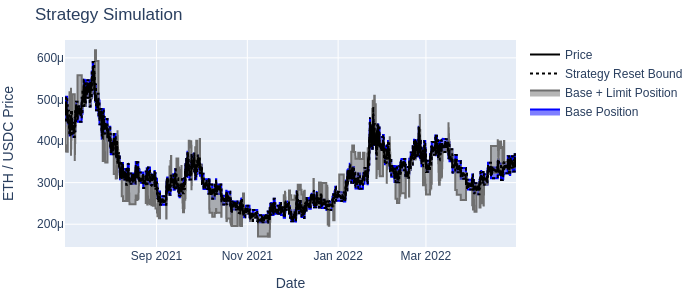

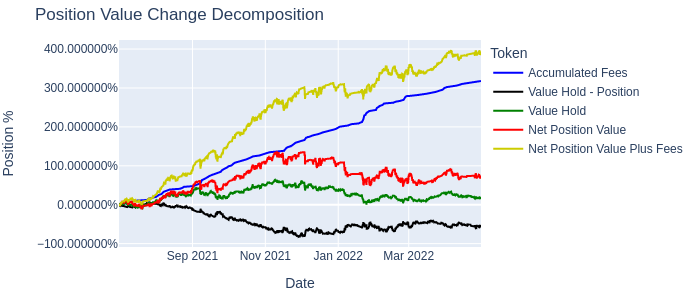

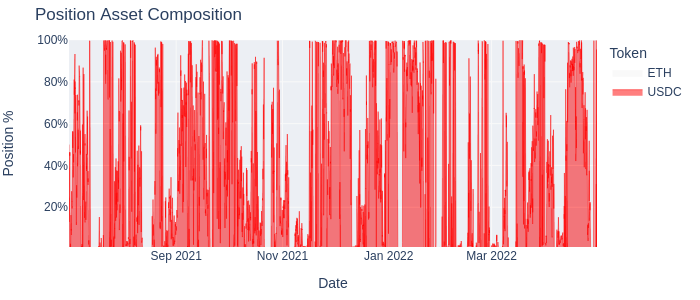

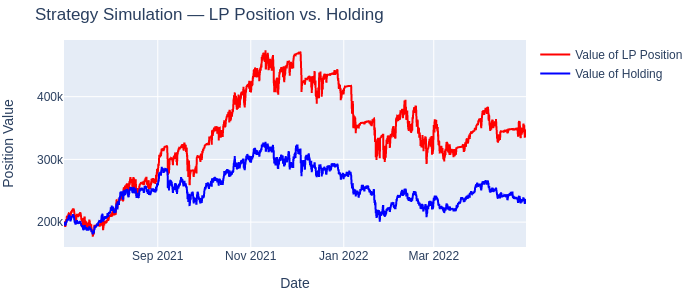

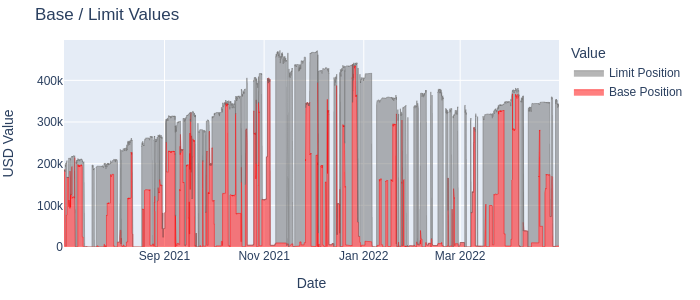

In [11]:
# Plots    
# ---------------------------------------------------------------------------------
# 1 - Plot the strategy ranges against the actual price
p = ActiveStrategyFramework.plot_strategy(data_strategy,'ETH / USDC Price','#0000FF')

# 2 - Return Decomposition, i.e. plot the value of the position over time, decomposing 
# the return into fee income vs. impermanent loss (this is an approximation, as this simulator 
# compounds fees, making the calculation tougher).
p = ActiveStrategyFramework.plot_position_return_decomposition(data_strategy)

# 3 - Asset Composition: Plot the composition of assets of the LP position over time.
p = ActiveStrategyFramework.plot_asset_composition(data_strategy,'USDC','ETH')

# 4 - Performance Comparison: Plot the value of the LP position vs. holding the initial assets.
p= ActiveStrategyFramework.plot_position_value(data_strategy)

# 5 - Position Composition: Plot the relative sizes of the base vs. limit positions
p = ActiveStrategyFramework.plot_position_composition(data_strategy)